# Fraser/Strait of Georgia Freshwater Chemistry Analysis
This is the data notebook
### Sections
   1. [Local Functions](#Local-Functions)
   2. [Load Data](#Load-Data)
   3. [TA regressions](#TA-regressions)
   4. [Fraser River Buoy pH Data](#Fraser-River-Buoy-pH-Data)
   5. [Freshwater DIC:TA scenarios](#Freshwater-DIC:TA-scenarios)

In [345]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import carbonate
import os
import gsw
import cmocean
from datetime import datetime, timedelta
from scipy import io, signal
from matplotlib import gridspec, cm, colors

%matplotlib inline

In [347]:
plt.rcParams['font.size'] = 12

## Local Functions

In [3]:
def export_TA_record(TA_record):
    """
    """
    
    # Create new forcing file
    Fraser_file = pd.read_csv(
        '/ocean/bmoorema/research/SOG/SOG-forcing/rivers/Fraser_total_31May2013.dat',
        delim_whitespace=True, names=['year', 'month', 'day', 'flow'],
    )
    Fraser_file = Fraser_file.join(pd.DataFrame(TA_record, columns=['TA']))
    #Fraser.to_csv('/ocean/bmoorema/research/SOG/SOG-forcing/rivers/FraserTA.dat', sep=' ', header=False, index=False)

## Load Data

In [12]:
# Load GRL2016 data
SOG_TA = {}
data = np.loadtxt('/home/bmoorema/Desktop/grl2016.raw')
SOG_TA['crid'] = data[:, 0]
SOG_TA['stn'] = data[:, 3]
SOG_TA['mnth'] = data[:, 4]
SOG_TA['day'] = data[:, 5]
SOG_TA['S'] = data[:, 10]
SOG_TA['dic'] = data[:, 13]
SOG_TA['dic_qf'] = data[:, 14]
SOG_TA['alk'] = data[:, 15]
SOG_TA['alk_qf'] = data[:, 16]

In [58]:
# Load Fraser Record
Fraser = {}
data = io.loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
Fraser['flow'] = data['fraser'][0][0][2].flatten()
Fraser['flow_filter'] = signal.filtfilt(*signal.butter(2, 0.1), Fraser['flow'])
Fraser['dQdt'] = np.diff(Fraser['flow_filter'])/24
Fraser['dQdt'] = np.append(Fraser['dQdt'][0], Fraser['dQdt'])
Fraser['date'] = [
    datetime.fromordinal(int(mtime[0]) - 366) +
    timedelta(days=float(mtime)%1)
    for mtime in data['fraser'][0][0][1]
]

In [7]:
# Load buoy pH record
buoy = {}
data = io.loadmat('/ocean/rich/home/metro/ecbuoy/matlab/ECBUOY.mat')
buoy['date'] = [
    datetime.fromordinal(int(mtime[0])) + timedelta(days=mtime[0]%1) - timedelta(days = 366)
    for mtime in data['ecbuoy'][0][0][4]
]
buoy['T'] = data['ecbuoy'][0][0][5]
buoy['S'] = gsw.conversions.SP_from_C(data['ecbuoy'][0][0][6] * 1e-3, buoy['T'], 0)
buoy['pH'] = carbonate.FindpHOnAllScales(data['ecbuoy'][0][0][16], buoy['T'], buoy['S'], 0, scale='NBS')

In [8]:
# SOG river temp
RiverTemp = 2.5 + (np.arange(365) - 52.8) * (19.3 - 2.5) / (232.9 - 52.8)
RiverTemp[233:] = 19.3 + (np.arange(365)[233:] - 232.9) * (2.5 - 19.3) / (334.4 - 232.9)
RiverTemp[:53] = 2.5
RiverTemp[335:] = 2.5

## TA regressions

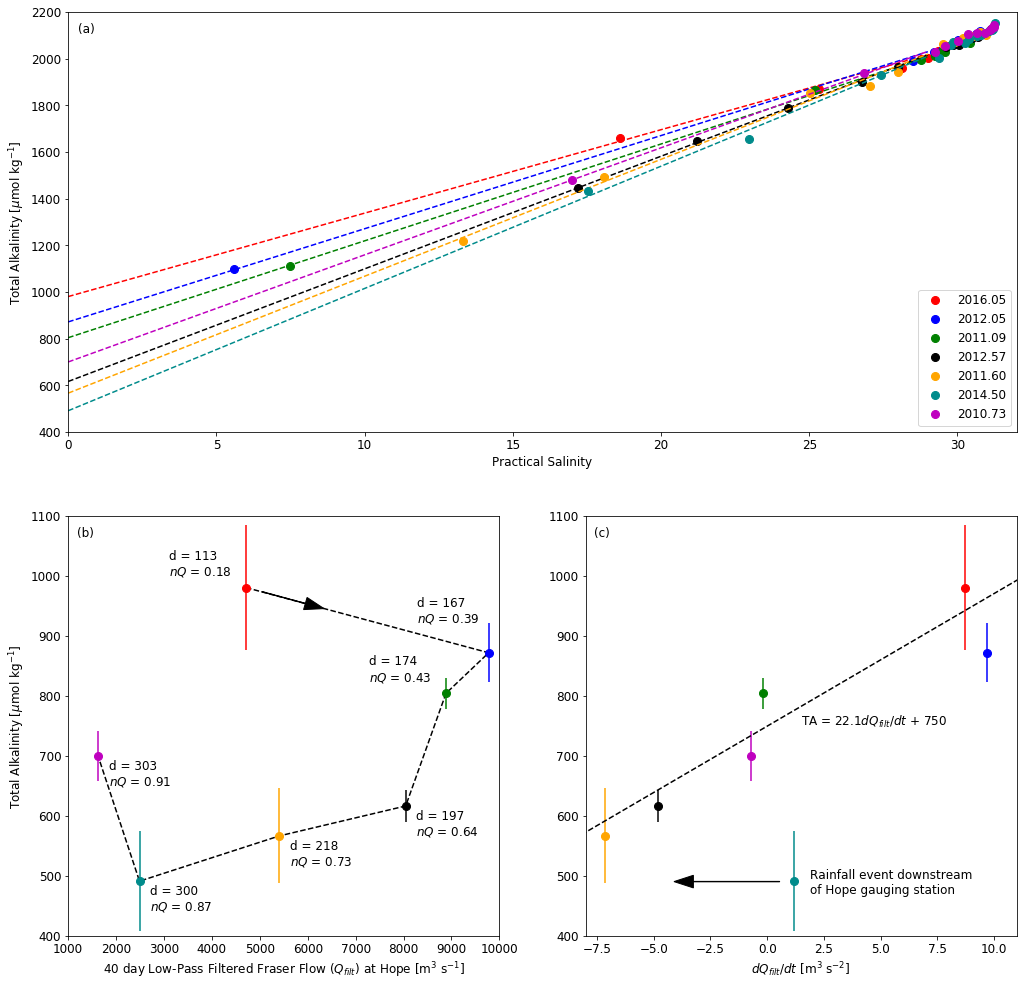

In [354]:
# Cruises to plot
cruises = [2016.05, 2012.05, 2011.09, 2012.57, 2011.60, 2014.50, 2010.73]
stations = [42., 42., 42., 39.5, 39.5, 42., 39.5]
palette = ['r', 'b', 'g', 'k', 'orange', 'darkcyan', 'm']

# Make figure
fig = plt.figure(figsize=(17, 17))
gs = gridspec.GridSpec(2, 2)
axs = [fig.add_subplot(gs[0, :])]
axs.extend([fig.add_subplot(gs[1, col]) for col in range(2)])

# Set axis properties
xlims = [[0, 32], [1000, 10000], [-8, 11]]
ylims = [[400, 2200], [400, 1100], [400, 1100]]
xlabels = [
    'Practical Salinity',
    '40 day Low-Pass Filtered Fraser Flow ($Q_{{filt}}$) at Hope [m$^3$ s$^{-1}$]',
    '$dQ_{{filt}}/dt$ [m$^{3}$ s$^{-2}$]',
]
ylabels = [
    'Total Alkalinity [$\mu$mol kg$^{-1}$]',
    'Total Alkalinity [$\mu$mol kg$^{-1}$]',
    '',    
]
plotlabels = [['(a)', 0.01], ['(b)', 0.02], ['(c)', 0.02]]
for ax, xlim, ylim, xlabel, ylabel, plotlabel in zip(axs, xlims, ylims, xlabels, ylabels, plotlabels):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.text(plotlabel[1], 0.95, plotlabel[0], transform=ax.transAxes)

# Endmember lists
x_reg, y_reg = [], []
x_hist, y_hist = [], []

# ------------- Loop through cruises ------------------------
for cruise, station, color in zip(cruises, stations, palette):    
    
    # Index
    index = (
        (SOG_TA['crid'] == cruise) &
        (SOG_TA['stn'] == station) &
        ((SOG_TA['alk_qf'] == 2) | (SOG_TA['alk_qf'] == 6))
    )
    
    # Fit TA to salinity
    S_fit = sm.OLS(SOG_TA['alk'][index], sm.add_constant(SOG_TA['S'][index])).fit()
    
    # Flow metrics
    month, day = int(SOG_TA['mnth'][index][0]), int(SOG_TA['day'][index][0])
    flowindex = [
        abs(np.array(Fraser['date']) - datetime(int(cruise), *yearday)).argmin()
        for yearday in [[month, day], [1, 1], [12, 31]]
    ]
    yearday = (Fraser['date'][flowindex[0]] - Fraser['date'][flowindex[1]]).days
    intQ = Fraser['flow'][flowindex[1]: flowindex[0]].sum() / Fraser['flow'][flowindex[1]: flowindex[2]].sum()
    
    # Salinity Regression Plot
    axs[0].plot(SOG_TA['S'][index], SOG_TA['alk'][index], 'o', color=color, markersize=8, label=f'{cruise:.2f}')
    axs[0].plot(np.arange(30), S_fit.params[1] * np.arange(30) + S_fit.params[0], '--', color=color)
    
    # Endmember Plots
    metrics = [Fraser['flow_filter'][flowindex[0]], Fraser['dQdt'][flowindex[0]]]
    for i, ax, x in zip(range(2), axs[1:], metrics):
        ax.errorbar(
            x, S_fit.params[0],
            S_fit.conf_int()[0][1] - S_fit.params[0],
            fmt='o', color=color, markersize=8
        )
        if i == 1 and cruise != 2014.50:
            x_reg.append(x)
            y_reg.append(S_fit.params[0])
        elif i == 0:
            x_shift = 220
            y_shift = -50
            if cruise == 2016.05 or cruise == 2011.09:
                x_shift = -1600
                y_shift = 20
            elif cruise == 2012.05:
                x_shift = -1500
                y_shift = 50
            ax.text(x + x_shift, S_fit.params[0] + y_shift, f'd = {yearday}\n$nQ$ = {intQ:.2f}')
            x_hist.append(x)
            y_hist.append(S_fit.params[0])

axs[1].plot(x_hist, y_hist, 'k--')
dQdt_fit = sm.OLS(np.array(y_reg), sm.add_constant(np.array(x_reg))).fit()
axs[2].plot(np.arange(-10, 15), 22.1 * np.arange(-10, 15) + 750, 'k--')
axs[2].text(0.5, 0.5, f'TA = 22.1$dQ_{{filt}}/dt$ + 750', transform=axs[2].transAxes)
axs[2].text(0.52, 0.1, 'Rainfall event downstream\nof Hope gauging station', transform=axs[2].transAxes)
axs[1].arrow(0.45, 0.82, 0.1, -0.028, head_width=0.03, fc='k', transform=axs[1].transAxes)
axs[2].arrow(0.45, 0.13, -0.2, 0, head_width=0.03, fc='k', transform=axs[2].transAxes)
axs[0].legend(loc=4)
plt.show()

## Fraser River Buoy pH Data

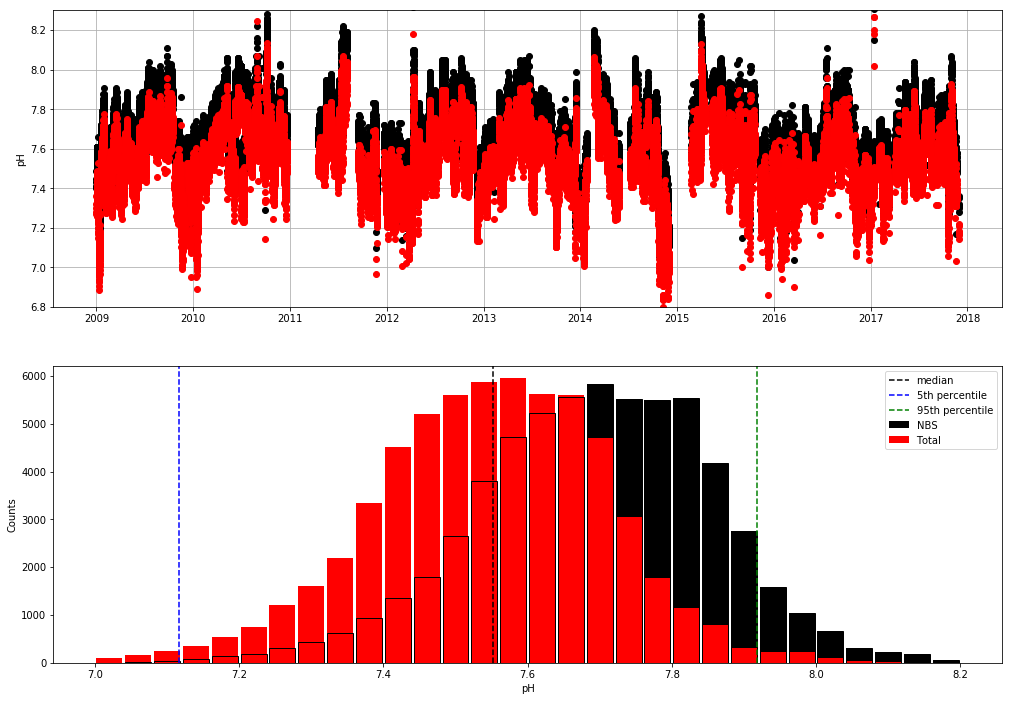

In [10]:
# pH Stats
median = np.nanmedian(buoy['pH']['total'])
percentile_5 = np.nanpercentile(buoy['pH']['total'], 1)
percentile_95 = np.nanpercentile(buoy['pH']['total'], 99)

# Make Figure
fig, ax = plt.subplots(2, 1, figsize=(17, 12))
ax[0].plot(buoy['date'], buoy['pH']['NBS'], 'ko')
ax[0].plot(buoy['date'], buoy['pH']['total'], 'ro')
ax[0].set_ylim([6.8, 8.3])
ax[0].set_ylabel('pH')
ax[0].grid()

ax[1].hist(buoy['pH']['NBS'][~np.isnan(buoy['pH']['NBS'])], bins=30, range=[7, 8.2], rwidth=0.9, color='k', label='NBS')
ax[1].hist(buoy['pH']['total'][~np.isnan(buoy['pH']['total'])], bins=30, range=[7, 8.2], rwidth=0.9, color='r', label='Total')
ax[1].hist(buoy['pH']['NBS'][~np.isnan(buoy['pH']['NBS'])], bins=30, range=[7, 8.2], rwidth=0.9, color='k', fill=False)
ax[1].plot([median, median], [0, 6200], 'k--', label='median')
ax[1].plot([percentile_5, percentile_5], [0, 6200], 'b--', label='5th percentile')
ax[1].plot([percentile_95, percentile_95], [0, 6200], 'g--', label='95th percentile')
ax[1].set_ylim([0, 6200])
ax[1].set_xlabel('pH')
ax[1].set_ylabel('Counts')
ax[1].legend()
plt.show()

## Freshwater DIC:TA scenarios
Plot model freshwater DIC:TA as determined by TA and pH

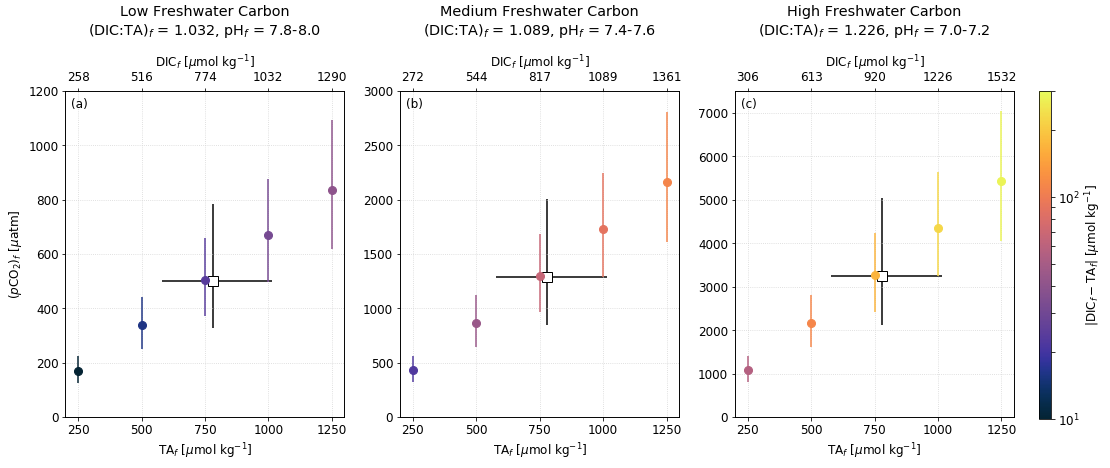

In [466]:
flowindex = [
    abs(np.array(Fraser['date']) - date).argmin()
    for date in [datetime(2001, 1, 1), datetime(2012, 12, 31)]
]
TA_record = 22.1*Fraser['dQdt'][slice(*flowindex)] + 750
TA_percentile = [np.percentile(TA_record, 1), np.percentile(TA_record, 50), np.percentile(TA_record, 99)]
TA_mesh, T_mesh = np.meshgrid(TA_record, np.arange(2.5, 20))

DICTAs = [1.032, 1.089, 1.226]
TAs = [250, 500, 750, 1000, 1250]
pHs = {'Low': '7.8-8.0', 'Medium': '7.4-7.6', 'High': '7.0-7.2'}
ylims = [[0, 1200], [0, 3000], [0, 7500]]
plotlabels = ['(a)', '(b)', '(c)']

fig, axs = plt.subplots(1, 3, figsize=(17, 6))
axs[0].set_ylabel('($p$CO$_2$)$_f$ [$\mu$atm]')

for ax, ylim, plotlabel, DICTA, pH in zip(axs, ylims, plotlabels, DICTAs, pHs.items()):
    ax.xaxis.set_ticks(TAs)
    ax.set_xlim([200, 1300])
    ax.set_ylim(ylim)
    ax.set_xlabel('TA$_f$ [$\mu$mol kg$^{-1}$]')
    ax.set_title(f'{pH[0]} Freshwater Carbon\n(DIC:TA)$_f$ = {DICTA:.3f}, pH$_f$ = {pH[1]}', y=1.15)
    ax.grid(color='lightgray', linestyle=':')
    ax.text(0.02, 0.95, plotlabel, transform=ax.transAxes)
    ax2 = ax.twiny()
    ax2.xaxis.set_ticks([TA*DICTA for TA in TAs])
    ax2.set_xlim([200*DICTA, 1300*DICTA])
    ax2.set_ylim(ylim)
    ax2.set_xlabel('DIC$_f$ [$\mu$mol kg$^{-1}$]')
    
    # Plot constant scenarios
    for TA in TAs:
        data = carbonate.calc_carbonate([TA, TA*DICTA], 0, 0, np.arange(2.5, 19.4, 0.1), 0, 0, params=['TA', 'TC'])
        pCO2_percentile = [np.percentile(data['pCO2'], 1), np.percentile(data['pCO2'], 50), np.percentile(data['pCO2'], 99)]
        c = ax.scatter(
            TA, pCO2_percentile[1], s=0, c=TA*DICTA-TA, norm=colors.LogNorm(vmin=10, vmax=300), cmap=cmocean.cm.thermal,
        )
        cax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
        cbar = fig.colorbar(c, cax=cax)
        ax.errorbar(
            TA, pCO2_percentile[1], yerr=[[pCO2_percentile[1] - pCO2_percentile[0]], [pCO2_percentile[2] - pCO2_percentile[1]]],
            fmt='o', markersize=8, color=cbar.to_rgba(TA*DICTA-TA),
        )
        cbar.remove()
    
    # Plot flow dependent scenario
    data = carbonate.calc_carbonate([TA_mesh, TA_mesh*DICTA], 0, 0, T_mesh, 0, 0, params=['TA', 'TC'])
    pCO2_percentile = [np.percentile(data['pCO2'], 1), np.percentile(data['pCO2'], 50), np.percentile(data['pCO2'], 99)]
    ax.errorbar(
        780, pCO2_percentile[1],
        yerr=[[pCO2_percentile[1] - pCO2_percentile[0]], [pCO2_percentile[2] - pCO2_percentile[1]]],
        xerr=[[780 - TA_percentile[0]], [TA_percentile[2] - 780]],
        fmt='s', markersize=10, markerfacecolor='w', color='k', zorder=0
    )

cax = fig.add_axes([0.92, 0.12, 0.01, 0.76])
cbar = fig.colorbar(c, cax=cax, label='$|$DIC$_f-$TA$_f|$ [$\mu$mol kg$^{-1}$]')
plt.show()